In [19]:
# !pip install scipy statsmodels

In [20]:
import numpy as np
import scipy.optimize as opt
import scipy
import time
import statsmodels.api as sm
import pandas as pd 
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Suppress FutureWarnings

np.set_printoptions(suppress=True)
np.random.seed(44042)

---- 

# Replicating Arcidiacono Miller (2011), Table 1 Column (7)

In this case, the time-invariant type (bus model, say) is unobserved _but_ accounted for in estimation via the EM algorithm. Time dummies are included to proxy for aggregate effects.  

In [21]:
# Parameter values
alpha = np.array([2, -0.15, 1, 0.9, 0.4]) # θ_0, θ_1, θ_2, β, Pr(s = 0)

T = 20    # Time periods
N = 2000  # Number of individuals
burnin = 10
T2 = 10

Grids for mileage (time-varying characteristic) and route characteristic (time-invariant).

In [22]:
# mileage 
x1 = np.arange(0, 25.125, 0.125)
x1l = len(x1)
# route char
x2 = np.arange(0.25, 1.26, 0.01)
x2l = len(x2)
# discrete type
x3 = np.arange(0, 2, 1)
x3l = len(x3)

From Equation 7.2 (p. 1852), 
$$
f_2(x_{1, t+1} | x_{t}) = 1\{x_{1, t+1} \geq x_{t}\} [ e^{-x_2(x_{1, t+1} - x_{t})} - e^{-x_2(0.125 + x_{1, t+1} - x_{t})} ]
$$
Note $f_1(x_{1, t+1} | x_{t}) = f_1(x_{1, t+1} | 0)$. Rows are $x_t$ and columns are $x_{t+1}$.

In [23]:
def xgrid(x1, x2, x1l, x2l):
    x1ub = np.concatenate([x1[1:], [np.inf]])
    xtran = np.zeros((x1l * x2l, x1l))  # Placeholder for transition matrix
    xtranc = np.zeros((x1l, x1l, x2l))  # Placeholder for cumulative transition matrix
    xtran_slice = np.zeros((x1l, x1l))
    for j in range(x2l):
        for i in range(x1l):
            xtran_slice[:, i] = (x1[i] >= x1) * ( np.exp(- x2[j] * (x1[i] - x1)) - np.exp(- x2[j] * (x1ub[i] - x1)) )
        xtran[x1l * j : x1l * (j + 1), :] = xtran_slice / xtran_slice.sum(axis = 1, keepdims=True)
        xtranc[:, :, j] = np.clip(np.cumsum(xtran_slice, axis = 1), 0.0, 1.0)
    return xtran, xtranc

xtran, xtranc = xgrid(x1, x2, x1l, x2l)
xtran[:4, :4]

array([[0.03076677, 0.02982017, 0.0289027 , 0.02801346],
       [0.        , 0.03076677, 0.02982017, 0.0289027 ],
       [0.        , 0.        , 0.03076677, 0.02982017],
       [0.        , 0.        , 0.        , 0.03076677]])

### Simulate Engine Replacement Data (```genbus4.m```)

$$
u_1(x_{1t}, s) = 0 \quad\quad\quad\quad u_2(x_{1t}, s) = \theta_0 + \theta_1 \min\{x_{1t}, 25\} + \theta_2 s + \phi_t
$$

In [24]:
def flowpayoff_replace(alpha, phi, x1, x3, t): 
    return 0.0

def flowpayoff_noreplace(alpha, phi, x1, x3, t): 
    return alpha[0] + alpha[1] * x1 + alpha[2] * x3 + phi[t]

Define the choice-specific conditional value function, $v_{jt}(z_t)$, as the flow payoff of action $j$ without $\varepsilon_{jt}$ plus the expected future utility conditional on following the optimal decision rule from period t + 1 on:
$$
v_{jt}(z_t) = u_{jt}(z_t) + \beta \sum_{z_{t+1}} V_{t+1}(z_{t+1}) f_{jt}(z_{t+1} | z_{t})
$$
where $V_{t+1}(z_{t+1}) = \int_{\varepsilon_{t+1}} \max\{v_{1t+1}(z_t+1), v_{2t+1}(z_t+1)\} dF(\varepsilon_{t+1})$. Assuming $\varepsilon_{t+1} \sim EVT1$ i.i.d. across choices and over time, 
$$
V_{t+1}(z_{t+1}) = \int_{\varepsilon_{t+1}} \max\{v_{1t+1}(z_t+1) + \varepsilon_{1t+1}, v_{2t+1}(z_t+1)  + \varepsilon_{2t+1}\} dF(\varepsilon_{t+1}) = \gamma_{Euler} + \ln \bigg( e^{v_{1t+1}(z_t+1)} + e^{v_{2t+1}(z_t+1)} \bigg)
$$
See Equation 2.4 and Equation 14 in [Llull's notes](https://joanllull.github.io/Structural_micro/Structural_micro_3.pdf). 

In [25]:
def conditional_value_function(beta, u_zt, V_ztprime, f_ztprime_zt):
    return u_zt + beta * np.dot(f_ztprime_zt, V_ztprime)

def Emax(v_replace, v_noreplace):
    return np.euler_gamma + np.logaddexp( v_replace, v_noreplace )

Recall $v_{jt}(z_t)$ always takes the standpoint of being at time $t$ _just before_ $\varepsilon$ is realized. 

If you take the renewal action this period, you go back to zero and hence the relevant transition to the future is $f_t(x_{t+1} | 0)$. 

If you do not take the renewal action, the relevant transition depends on your accumulated mileage, $f_t(x_{t+1} | x_t)$.

In [26]:
def BackwardInduction_V(alpha, timeFE, x1, x2, x3, x1l, x2l, x3l, TT):
    V = np.zeros((x1l * x2l, 2, TT + 1)) 
    for t in range(TT - 1, 0, -1):
        for x3idx in range(x3l):
            for x2idx in range(x2l):
                for x1idx in range(x1l): # indexing x_{1t} as we enter the period 
                    v_replace   = conditional_value_function(alpha[3], flowpayoff_replace(alpha, timeFE, x1[x1idx], x3[x3idx], t),   V[x1l * x2idx : x1l * (x2idx + 1), x3[x3idx], t + 1], xtran[x1l * x2idx, :])
                    v_noreplace = conditional_value_function(alpha[3], flowpayoff_noreplace(alpha, timeFE, x1[x1idx], x3[x3idx], t), V[x1l * x2idx : x1l * (x2idx + 1), x3[x3idx], t + 1], xtran[x1l * x2idx + x1idx, :])
                    V[x1l * x2idx + x1idx, x3[x3idx], t] = Emax(v_replace, v_noreplace)
    return V 

In [27]:
def genbus(alpha, N, T, T2, burnin, xtran, xtranc, x1, x2, x3, x1l, x2l, x3l):
    
    timeFE = np.zeros(T + burnin + 1)
    for t in range(1, T + burnin + 1):
        timeFE[t] = .7 * timeFE[t] + .5 * scipy.stats.norm.ppf(np.random.rand()) # ensure rng stream consistency with matlab 

    V = BackwardInduction_V(alpha, timeFE, x1, x2, x3, x1l, x2l, x3l, T + burnin)

    x1idx = np.zeros((N, T2 + burnin + 1)).astype(int)
    x2idx = np.ceil( x2l * np.random.rand(N) - 1).astype(int)    # ensure rng stream consistency with matlab, not preserved by randint()
    x3idx  = (np.random.rand(N) > alpha[4]).astype(int)          # type
    Y = np.zeros((N, T2 + burnin + 1))
    X1 = np.zeros((N, T2 + burnin + 1))                          # accumulating mileage. all buses start at zero.  
    X2 = x2[x2idx]                                               # permanent characteristic
    p_replace = np.zeros((N, T2 + burnin + 1))
    Draw = np.random.rand(T2 + burnin, N).T                      # to ensure the same random draws as the matlab script are used (row-major vs column-major)
    Draw2 = np.random.rand(T2 + burnin, N).T

    for n in range(N):
        for t in range(T2 + burnin):
            v_replace   = conditional_value_function(alpha[3], flowpayoff_replace(alpha, timeFE, X1[n, t], x3idx[n], t),   V[x2idx[n] * x1l : (x2idx[n] + 1) * x1l, x3idx[n], t + 1], xtran[x2idx[n] * x1l, :])
            v_noreplace = conditional_value_function(alpha[3], flowpayoff_noreplace(alpha, timeFE, X1[n, t], x3idx[n], t), V[x2idx[n] * x1l : (x2idx[n] + 1) * x1l, x3idx[n], t + 1], xtran[x2idx[n] * x1l + x1idx[n, t], :])
            p_replace[n, t] = 1 / ( 1 + np.exp(v_noreplace - v_replace) )
            Y[n, t] = Draw[n, t] < p_replace[n, t] # Y = 1 <-> replace.
            x1idx[n, t + 1] = (1 - Y[n, t]) * np.sum((Draw2[n, t] * np.ones(x1l)) > xtranc[x1idx[n, t], :, x2idx[n]]) # if not replace, draw x_{1t+1} from mileage transition; if replace, x_{1t+1} = 0.
            X1[n, t + 1] = x1[x1idx[n, t + 1]]

    # The econometrician is assumed to see only the last T periods. (p.1853)  
    return Y[:, burnin:T2+burnin], X1[:, burnin:T2+burnin], X2, x1idx[:, burnin:T2+burnin], x2idx, x3idx, timeFE

----
## CCP Estimator

The CCP estimator makes uses the Hotz Miller result that there exists a real-valued function $\psi_k[p_t(z_t)]$ for any (potentially sub-optimal) choice $k = 1, \dots, J$ such that
$$
\psi_k[p_t(z_t)] ≡ V_t(z_t) − v_{kt}(z_t)
$$
to rewrite the choice-specific conditional value function as (for an arbitrary $k$)
$$
v_{jt}(z_t) = u_{jt}(z_t) + \beta \sum_{z_{t+1}} \bigg[ \psi_k[p_{t+1}(z_{t+1})] + v_{kt+1}(z_{t+1})\bigg] f_{jt}(z_{t+1} | z_{t})
$$
Now consider the sequences {[renew at $t$, renew at $t+1$]; [not renew at $t$, renew at $t+1$]}. Intuitively, because renewing tomorrow leads to the same state in the two sequences, the choice-specific conditional value functions will be the same for both sequences in all periods from $t+2$ onwards. 
To make use of this fact, use the Hotz Miller result to replace $v_{kt+1}(z_{t+1})$ in the above:
$$
v_{jt}(z_t) = u_{jt}(z_t) + \beta \sum_{z_{t+1}} \big[ u_{kt+1}(z_{t+1}) + \psi_k[p_{t+1}(z_{t+1})] \big] f_{jt}(z_{t+1} | z_{t}) + \beta^2 \sum_{z_{t+1}} \sum_{z_{t+2}} \big[ \psi_{k^\prime}[p_{t+2}(z_{t+2})] + v_{{k^\prime}t+2}(z_{t+2}) \big] f_{jt+1}(z_{t+2} | z_{t+1}) f_{jt}(z_{t+1} | z_{t})
$$
The difference between any two paths that lead to taking the renewal action $k$ at $t+1$ is therefore 
$$
v_{jt}(z_t) - v_{j^\prime t}(z_t) = u_{jt}(z_t) - u_{j^\prime t}(z_t) + \beta \sum_{z_{t+1}} \big[ u_{kt+1}(z_{t+1}) + \psi_k[p_{t+1}(z_{t+1})] \big] \big[f_{jt}(z_{t+1} | z_{t}) - f_{j^\prime t}(z_{t+1} | z_{t}) \big]
$$ 
Notice that there is a **typo** in Equations 3.13 and 7.3 of the published version, which contain $- \psi_k$ instead of $+ \psi_k$. The correct formula appears in follow-up Arcidiacono Miller papers and [Llull's notes](https://joanllull.github.io/Structural_micro/Structural_micro_4.pdf) (see e.g. equation 15).

Let $j$ = not replace, $j^\prime$ = replace, and $k$ = replace. Then 
$$
v_{jt}(z_t) - v_{j^\prime t}(z_t) = u_{jt}(z_t) + \beta \sum_{z_{t+1}} \psi_{j^\prime}[p_{t+1}(z_{t+1})] \big[f_{jt}(z_{t+1} | z_{t}) - f_{j^\prime t}(z_{t+1} | z_{t}) \big]
$$ 

The columns used in the "flexible logits" below. We reshape Y from $Y[n, t]$ into a column vector that iterates primarily over $n$ and secondarily over $t$.

In the EM case, we _augment_ the data by constructing a column that contains the unobserved state. In this instance, because there are two possible unobserved states, this duplicates the data.

In [28]:
def logit_covariates_s(N, T2, X1, X2, x3, x3l):

    x1_r = X1.T.reshape(N * T2) / 10
    x1_r = np.vstack( [x1_r] * x3l ).flatten()
    x2_r = np.tile(X2, (1, T2))
    x2_r = np.vstack( [x2_r.T] * x3l ).flatten()
    x3_r = np.repeat( x3, (N * T2))
    t_r = np.repeat(np.arange(1, T2 + 1), N)
    t_r = np.vstack( [t_r.T] * x3l ).flatten()
    td = np.zeros((2*N*T2, T2 - 1))
    for t in range(T2 - 1):
        td[:, t] = t_r == t + 2

    xx = np.empty((x3l * N * T2, 12))
    xx[:, 0]  = 1
    xx[:, 1]  = x1_r
    xx[:, 2]  = x2_r
    xx[:, 3]  = x1_r * x2_r
    xx[:, 4]  = x1_r ** 2
    xx[:, 5]  = x2_r ** 2
    xx[:, 6]  = x3_r
    xx[:, 7]  = x3_r * x1_r
    xx[:, 8]  = x3_r * x2_r
    xx[:, 9]  = x3_r * x1_r * x2_r
    xx[:, 10] = x3_r * x1_r ** 2
    xx[:, 11] = x3_r * x2_r ** 2

    return xx, td

Columns used in the flexible logits, extrapolated to the entire state space.

In [29]:
def logit_covariates_z(x1, x2, x3, x1l, x2l, x3l, td): 
    x1r = np.tile(x1, x2l) / 10
    x2r = np.repeat(x2, x1l)
    RX1 = np.column_stack([np.ones(x2l * x1l), x1r, x2r, x1r * x2r, x1r ** 2, x2r ** 2])
    return np.column_stack([RX1, x3 * RX1, td])

Under the assumption that $\varepsilon \sim EVT1$, $\psi_k[p_{t+1}(z_{t+1})] = - \ln p_{kt+1}(z_{t+1})$:
$$
v_{jt}(z_t) - v_{j^\prime t}(z_t) = u_{jt}(z_t) - \beta \sum_{z_{t+1}}\ln p_{j^\prime t+1}(z_{t+1}) \big[f_{jt}(z_{t+1} | z_{t}) - f_{j^\prime t}(z_{t+1} | z_{t}) \big]
$$ 

The Supp Mat contains the formula for $\psi_k()$ under a nested logit assumption. 
Fosgerau et al. (2021) show how to more generally compute $\psi_k()$ when you observe $p$ and can simulate from $F(\varepsilon)$.

In [30]:
def fvdata(b1, N, T, x1idx, x2idx, x3idx, x1, x2, x3, x1l, x2l, x3l, xtran):

    td = np.zeros((x1l * x2l, T - 1))
    # Compute - ln[p_{1t+1}(x_{t+1}, s)] over the entire state space using estimated logit, which has Y = 1{Renew}
    psi_renew = np.zeros((x1l * x2l, x3l, T + 1))
    for t in range(1, T):
        td[:, t - 1] = 1
        if t > 1: 
            td[:, t - 2] = 0
        for s in range(x3l):
            psi_renew[:, s, t] = np.log1p(np.exp(- logit_covariates_z(x1, x2, x3[s], x1l, x2l, x3l, td) @ b1))

    # Compute \sum_s ln[p_{1t+1}(x_{t+1}, s)] [f_2(x_{t+1}|x_t) − f_1(x_{t+1}|x_t)] -- see Supp. Mat., p.12 
    Deltav = np.zeros((N, T, x3l))
    for n in range(N):
        for t in range(T):
            for s in range(x3l):
                Deltav[n, t, s] = np.dot(psi_renew[x1l * x2idx[n] : x1l * (x2idx[n] + 1), s, t + 1],  xtran[x1l * x2idx[n] + x1idx[n, t], :] - xtran[x1l * x2idx[n], :])

    return Deltav.reshape(N* T * x3l, 1, order = 'F'), psi_renew

Let 1 be the decision to renew and 0 the decision to keep. Then the likelihood contribution of an individual observation treating the unobserved state as observed is 
$$
Pr(Y_{it} = 1 | X_{it}, s_i; \theta) = 
\frac{\exp( v_{1t}(z_t) )}{\exp( v_{1 t}(z_t) ) + \exp( v_{0 t}(z_t) )} = 
\frac{1}{1 + \exp( v_{0 t}(z_t) - v_{1 t}(z_t))} =
\frac{1}{1 + e^{- u_{1t}(z_t) - \beta \sum_{z_{t+1}} \ln[p_{1t+1}(z_{t+1})] \big[f_{0t}(z_{t+1} | z_{t}) - f_{1 t}(z_{t+1} | z_{t}) \big] }}
\equiv Pr(Y_{it} = 1 | X_{it}, s_i; \theta, p)
$$
We do not observe $s_i$. Integrating out $s_i$, 
$$
Pr(\bm{Y}_{i} | \bm{X}_{i}; \theta, \pi, p) = \sum_{s} \pi(s | \bm{X}_{i}) \prod_t Pr(Y_{it} = 1 | X_{it}, s; \theta, p)
$$
We could now compute the maximum likelihood estimator as $\arg\max_{\pi, \theta} \sum_i \ln Pr(\bm{Y}_{i} | \bm{X}_{i}; \theta, \pi, p)$. 
Expectation Maximization simply consists in iterating between maximizing wrt $\pi$ and $\theta$.

Start with guesses $\pi^m, \theta^m, p_1^m$ at iteration $m$. Then by Bayes' rule 
$$
q_{i}(\theta, \pi, p) \equiv Pr(s_i = s | \bm{X}_{i}, \bm{Y}_{i}; \theta, \pi, p) = \frac{Pr(\bm{Y}_{i} | \bm{X}_{i}, s_i = s; \theta, p) Pr(s_i = s| \bm{X}_{i})}{\sum_{s^\prime} Pr(\bm{Y}_{i} | \bm{X}_{i}, s_i = s^\prime; \theta, p) Pr(s_i = s^\prime| \bm{X}_{i})} = \frac{Pr(\bm{Y}_{i} | \bm{X}_{i}, s; \theta, p) \pi( s | \bm{X}_{i})}{\sum_{s^\prime} Pr(\bm{Y}_{i} | \bm{X}_{i}, s^\prime; \theta, p) \pi( s^\prime | \bm{X}_{i})}
$$
This suggests Step 1, p.1831:
$$
q^{m+1}_{i}(s; \theta^m, \pi^m, p) = \frac{Pr(\bm{Y}_{i} | \bm{X}_{i}, s; \theta^m, p) \pi^{m}( s | \bm{X}_{i})}{\sum_{s^\prime} Pr(\bm{Y}_{i} | \bm{X}_{i}, s^\prime; \theta^m, p) \pi^{m}( s^\prime | \bm{X}_{i})}
$$
Next, note that 
$$
p_1(s, x) = Pr(Y_{it} = 1 | X_{it} = x, s_i = s)
= \frac{E ( 1\{Y_{it} = 1\} \times 1\{s_i = s\} | X_{it} = x) }{E(1\{s_i = s\} | X_{it} = x) }
= \frac{E [ 1\{Y_{it} = 1\} E ( 1\{s_i = s\} | \bm{Y}_{i}, \bm{X}_{i}) | X_{it} = x] }{E [ E ( 1\{s_i = s\} | \bm{Y}_{i}, \bm{X}_{i}) | X_{it} = x] }
= \frac{E [ 1\{Y_{it} = 1\} q_{i}(s) | X_{it} = x] }{E [ q_{i}(s) | X_{it} = x] }
$$
suggesting Step 3, p. 1832: 
$$
p^{m+1}_1(s, x) = \frac{ \sum_i \sum_t 1\{Y_{it} = 1\} q^{m+1}_{i}(s) }{ \sum_i \sum_t q^{m+1}_{i}(s) }
$$ 
We also use the fact that the unconditional probability of state $s$ is the integral over the conditional probabilities to form Step 2,  
$$
\pi^{m+1}( s; \theta^m, p ) = \frac{1}{N} \sum_i q^{m+1}_{i}(s; \theta^m, \pi^m, p)
$$
Note this step is different from the one implemented below, which instead is discussed in Supp Mat Section B.1.4.


These three steps make up the _expectation_ part of the EM algorithm. 
Step 4 is the _maximization_ part: with $q^{m+1}_{i}(s)$ and $p^{m+1}_1(s, x)$ in hand, we update $\theta^{m+1}$ as
$$
\arg \max_{\theta} \sum_i \sum_t \sum_{s} q^{m+1}_{i}(s) \ln Pr(Y_{it} = 1 | X_{it}, s; \theta, p^{m+1})
$$


Note that AM parameterize the probability of latent class as a flexible logit based on (observed) first period characteristics: 
$$
\pi(s_i = 1 | X_{i1}) = \frac{e^{X_{i1}\delta}}{1 + e^{X_{i1}\delta}}
$$
So that Step 2 is replaced with 
$$
\delta^{m+1} = \arg\max_\delta \sum_i \log \bigg( \sum_{s}  \pi(s_i | X_{i1}) \prod_t Pr(Y_{it} = 1 | X_{it}, s_i; \theta^m) \bigg)
$$



---- 

## Simulation and Estimation

In [31]:
def X_initial_conditions(N, X1, X2):
    return np.column_stack([np.ones((N)), X1[:N, 0], X2])

def l_initial_conditions_log(initcond_pars, Xinitcond, logl_is):
    Xb = Xinitcond @ initcond_pars
    logp_s1 = - np.logaddexp(0, -Xb)
    logp_s = np.column_stack([logp_s1, - Xb + logp_s1])
    summ = np.sum( np.exp(logp_s + logl_is), axis = 1)
    return - np.sum( np.log( summ / np.min(summ) ) + np.log(np.min(summ)) ) 

In [32]:
def logPr_Update(b, Y, X):
    Xb = X @ b
    return (1 - Y) * Xb - np.logaddexp(0, Xb)

def step1_log(initcond_pars, Xinitcond, logl_is):
    Xb = Xinitcond @ initcond_pars
    logp_s1 = - np.logaddexp(0, -Xb)
    logp_s = np.column_stack([logp_s1, - Xb + logp_s1])
    summ = np.exp(logp_s + logl_is)
    return summ / summ.sum(axis = 1, keepdims=True)

In [33]:
def logl_logit_weighted(b, Y, X, w): 
    Xb = X @ b
    return np.sum( w * (np.logaddexp(0, -Xb) + (1 - Y) * Xb) )

Initialize the parameter vectors we are iterating over. We estimate logits that ignore unobserved heterogeneity to get starting values.

In [34]:
Y, X1, X2, x1idx, x2idx, x3idx, timeFE = genbus(alpha, N, T, T2, burnin, xtran, xtranc, x1, x2, x3, x1l, x2l, x3l)

In [35]:
Xinitcond = X_initial_conditions(N, X1, X2)

yy = np.tile(Y.reshape(N * T2, order = 'F'), x3l)
xx, td = logit_covariates_s(N, T2, X1, X2, x3, x3l)
xxt = np.column_stack([xx, td])

logit_result = opt.minimize(logl_logit_weighted, np.zeros(xxt.shape[1]), args = (yy, xxt, 1))
logit_pars = logit_result.x
Deltav, psi_renew = fvdata(logit_pars, N, T2, x1idx, x2idx, x3idx, x1, x2, x3, x1l, x2l, x3l, xtran)
RHS_7_3 = np.column_stack([ np.ones(x3l * N * T2), np.tile(X1.reshape(N * T2, order = 'F'), x3l), np.repeat( x3, (N * T2)), Deltav, td[:, :-1]])

# structural parameters
ccp_result = opt.minimize(logl_logit_weighted, np.zeros(RHS_7_3.shape[1]), args = (yy, - RHS_7_3, 1))
ccp_pars = ccp_result.x
ccp_pars[2] = .5 # nudge the effect of the unobserved state in the right direction.

# delta (see Supp Mat B.1.4)
initcond_pars = np.zeros(Xinitcond.shape[1])

##### EM Iteration With Initial Conditions Fix

In [36]:
cond = 0 
lp = []
iter = 0
max_iter = 1000
tol = 1e-7

while (cond == 0) & (iter < max_iter + 1):
    if (iter > 0) & (iter % 10 == 0): 
        print(f"Iteration {iter}/{max_iter}. Estimated pi: {np.round(np.mean( q_NxS, axis = 0), 3)}. Structural parameters: {np.round(ccp_pars[:4], 2)}")

    # \sum_t log( l_{it} ) 
    logl_is = np.sum(logPr_Update(ccp_pars, yy, RHS_7_3).reshape(N, T2, x3l, order = 'F'), axis = 1)

    # update parameters for \pi(s | x) [Step 2 with initial conditions]
    initcond_result = opt.minimize(l_initial_conditions_log, initcond_pars, args = (Xinitcond, logl_is))
    initcond_pars = initcond_result.x
    lp.append(initcond_result.fun)  
    
    q_NxS = step1_log(initcond_pars, Xinitcond, logl_is)
    q = np.vstack([q_NxS] * T2).reshape(-1, 1, order = 'F').flatten()
    
    # Step 3a
    logit_result = opt.minimize(logl_logit_weighted, logit_pars, args = (yy, xxt, q))
    logit_pars = logit_result.x

    # update RHS that treats s as observed
    Deltav, psi_renew = fvdata(logit_pars, N, T2, x1idx, x2idx, x3idx, x1, x2, x3, x1l, x2l, x3l, xtran)
    RHS_7_3 = np.column_stack([ np.ones(x3l * N * T2), np.tile(X1.reshape(N * T2, order = 'F'), x3l), np.repeat( x3, (N * T2)), Deltav, td[:, :-1]])

    # Step 4
    ccp_result = opt.minimize(logl_logit_weighted, ccp_pars, args = (yy, - RHS_7_3, q))
    ccp_pars = ccp_result.x
    
    # checking convergence 
    if iter > 26:
        junk  = np.abs((lp[iter] - lp[iter - 25]) / lp[iter]) < tol
        junk2 = np.abs((lp[iter-1] - lp[iter - 26]) / lp[iter - 1]) < tol
        cond = junk2 * junk
    iter += 1

Iteration 10/1000. Estimated pi: [0.946 0.054]. Structural parameters: [ 2.12 -0.28  1.06 -0.03]
Iteration 20/1000. Estimated pi: [0.953 0.047]. Structural parameters: [ 2.12 -0.28  1.16 -0.03]
Iteration 30/1000. Estimated pi: [0.954 0.046]. Structural parameters: [ 2.12 -0.28  1.17 -0.03]
Iteration 40/1000. Estimated pi: [0.954 0.046]. Structural parameters: [ 2.12 -0.28  1.18 -0.03]
Iteration 50/1000. Estimated pi: [0.954 0.046]. Structural parameters: [ 2.12 -0.28  1.18 -0.03]


---- 

## Monte Carlo

In [38]:
# starting values for FIML and CCP
Tccp  = []
Bccp  = []

for MC in range(50):
    
   Y, X1, X2, x1idx, x2idx, x3idx, timeFE = genbus(alpha, N, T, T2, burnin, xtran, xtranc, x1, x2, x3, x1l, x2l, x3l)
   
   ## CCP estimation
   time_start = time.time()

   Xinitcond = X_initial_conditions(N, X1, X2)

   yy = np.tile(Y.reshape(N * T2, order = 'F'), x3l)
   xx, td = logit_covariates_s(N, T2, X1, X2, x3, x3l)
   xxt = np.column_stack([xx, td])

   logit_result = opt.minimize(logl_logit_weighted, np.zeros(xxt.shape[1]), args = (yy, xxt, 1))
   logit_pars = logit_result.x
   Deltav, psi_renew = fvdata(logit_pars, N, T2, x1idx, x2idx, x3idx, x1, x2, x3, x1l, x2l, x3l, xtran)
   RHS_7_3 = np.column_stack([ np.ones(x3l * N * T2), np.tile(X1.reshape(N * T2, order = 'F'), x3l), np.repeat( x3, (N * T2)), Deltav, td[:, :-1]])

   # structural parameters
   ccp_result = opt.minimize(logl_logit_weighted, np.zeros(RHS_7_3.shape[1]), args = (yy, - RHS_7_3, 1))
   ccp_pars = ccp_result.x
   ccp_pars[2] = .5 # nudge the effect of the unobserved state in the right direction.

   # delta (see Supp Mat B.1.4)
   initcond_pars = np.zeros(Xinitcond.shape[1])

   cond = 0 
   lp = []
   iter = 0
   max_iter = 1000
   tol = 1e-7

   cond = 0 
   lp = []
   iter = 0
   max_iter = 1000
   tol = 1e-7

   while (cond == 0) & (iter < max_iter + 1):
      if (iter > 0) & (iter % 10 == 0): 
         print(f"Iteration {iter}/{max_iter}. Estimated pi: {np.round(np.mean( q_NxS, axis = 0), 3)}. Structural parameters: {np.round(ccp_pars[:4], 2)}")

      # \sum_t log( l_{it} ) 
      logl_is = np.sum(logPr_Update(ccp_pars, yy, RHS_7_3).reshape(N, T2, x3l, order = 'F'), axis = 1)

      # update parameters for \pi(s | x) [Step 2 with initial conditions]
      initcond_result = opt.minimize(l_initial_conditions_log, initcond_pars, args = (Xinitcond, logl_is))
      
      initcond_pars = initcond_result.x
      lp.append(initcond_result.fun)  
      
      q_NxS = step1_log(initcond_pars, Xinitcond, logl_is)
      q = np.vstack([q_NxS] * T2).reshape(-1, 1, order = 'F').flatten()
      
      # Step 3a
      logit_result = opt.minimize(logl_logit_weighted, logit_pars, args = (yy, xxt, q))
      logit_pars = logit_result.x

      # update RHS that treats s as observed
      Deltav, psi_renew = fvdata(logit_pars, N, T2, x1idx, x2idx, x3idx, x1, x2, x3, x1l, x2l, x3l, xtran)
      RHS_7_3 = np.column_stack([ np.ones(x3l * N * T2), np.tile(X1.reshape(N * T2, order = 'F'), x3l), np.repeat( x3, (N * T2)), Deltav, td[:, :-1]])

      # Step 4
      ccp_result = opt.minimize(logl_logit_weighted, ccp_pars, args = (yy, - RHS_7_3, q))
      ccp_pars = ccp_result.x
      
      # checking convergence 
      if iter > 100:
         junk  = np.abs((lp[iter] - lp[iter - 25]) / lp[iter]) < tol
         junk2 = np.abs((lp[iter-1] - lp[iter - 26]) / lp[iter - 1]) < tol
         cond = junk2 * junk
      iter += 1

   time_taken = time.time() - time_start
   Tccp.append(time_taken)
   Bccp.append(ccp_pars)
   print(f"MC {MC} / 50. CCP Time taken: {np.round(time_taken, 2)} seconds. Structural parameters: {np.round(ccp_pars[:4], 3)}. True parameters: {alpha[:4]}")

Iteration 10/1000. Estimated pi: [0.808 0.192]. Structural parameters: [ 2.2  -0.29  0.83  0.04]
Iteration 20/1000. Estimated pi: [0.792 0.208]. Structural parameters: [ 2.19 -0.29  0.84  0.04]
Iteration 30/1000. Estimated pi: [0.786 0.214]. Structural parameters: [ 2.19 -0.29  0.84  0.05]
Iteration 40/1000. Estimated pi: [0.783 0.217]. Structural parameters: [ 2.18 -0.29  0.83  0.05]
Iteration 50/1000. Estimated pi: [0.78 0.22]. Structural parameters: [ 2.18 -0.29  0.83  0.05]
Iteration 60/1000. Estimated pi: [0.779 0.221]. Structural parameters: [ 2.18 -0.29  0.83  0.05]
Iteration 70/1000. Estimated pi: [0.778 0.222]. Structural parameters: [ 2.18 -0.29  0.82  0.05]
Iteration 80/1000. Estimated pi: [0.777 0.223]. Structural parameters: [ 2.18 -0.29  0.82  0.05]
Iteration 90/1000. Estimated pi: [0.777 0.223]. Structural parameters: [ 2.18 -0.29  0.82  0.05]
Iteration 100/1000. Estimated pi: [0.776 0.224]. Structural parameters: [ 2.18 -0.29  0.82  0.05]
Iteration 110/1000. Estimated p

In [44]:
Bccp_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.179904,-0.286832,0.822209,0.047996,0.034151,-0.289825,0.150808,0.450654,-0.876418,-0.148512,-0.038300,-0.169896
1,2.716566,-0.203646,0.740728,0.598884,-0.637768,-0.571474,-0.586532,-0.171932,-0.620708,0.107556,-0.805577,-1.398600
2,1.783201,-0.208108,0.861821,0.610344,0.079242,0.392297,0.795447,0.321907,1.412602,0.498359,1.508067,1.047982
3,2.345403,-0.232682,1.321844,0.314665,0.950371,0.731454,-0.013812,-0.139234,0.412008,-0.286663,0.124963,0.752402
4,2.337043,-0.292048,0.615915,-0.054428,0.054255,-0.934207,0.802047,0.449357,0.234427,-1.473538,-0.937024,0.192064
5,1.657987,-0.230910,0.857157,0.424685,0.998761,0.441808,0.067318,-0.539996,0.456474,1.073322,0.412185,0.468723
6,2.207972,-0.290807,0.962530,0.033092,-0.514591,-0.434567,0.185973,-0.191582,-0.009563,-0.601124,0.059993,0.351192
7,2.102016,-0.285825,0.712996,-0.041407,-0.524926,0.316828,1.047298,0.106906,-0.353164,0.417988,-0.098915,0.616021
8,1.839671,-0.294928,1.177599,-0.021972,0.093894,0.073235,0.301333,0.702783,0.203536,0.249556,0.346293,0.839353
9,2.114167,-0.220849,0.852171,0.475678,-0.056566,0.458718,-0.800897,0.127061,0.104615,-1.016335,-0.166188,0.960956


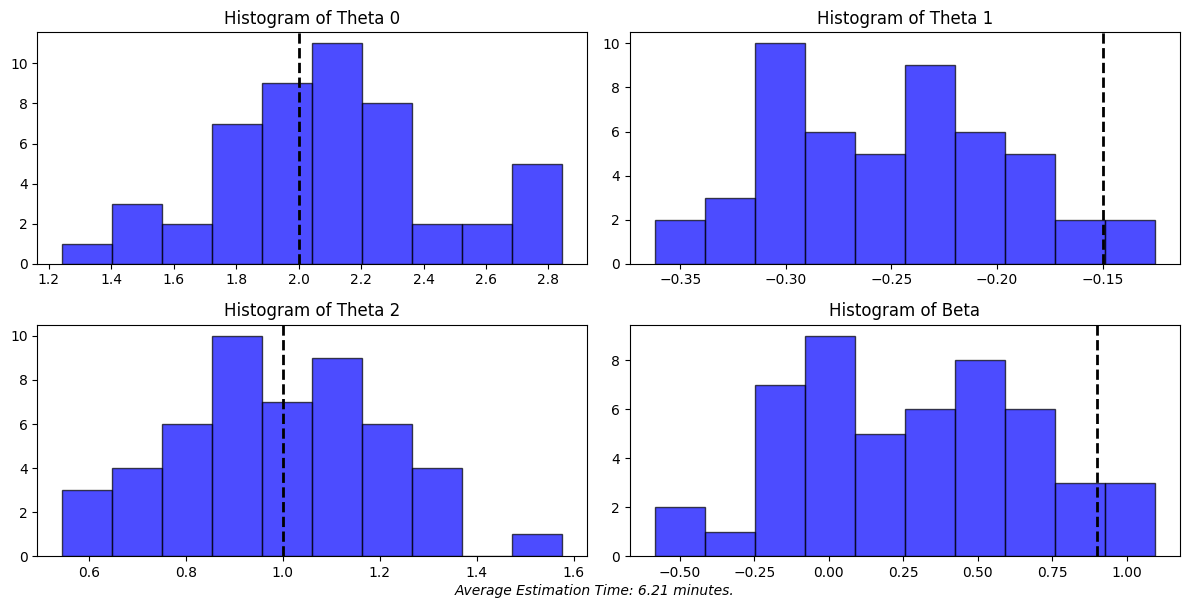

In [52]:
Bccp_df = pd.DataFrame(Bccp)
Bccp_df.columns = ["Theta 0", "Theta 1", "Theta 2", "Beta", "TimeFe1", "TimeFe2", "TimeFe3", "TimeFe4", "TimeFe5", "TimeFe6", "TimeFe7", "TimeFe8"]
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
for i, col in enumerate(Bccp_df.iloc[:, :4].columns):
    axes[i].hist(Bccp_df[col], bins=10, alpha=0.7, color='b', edgecolor='black')
    axes[i].axvline(alpha[i], color='black', linestyle='dashed', linewidth=2)
    axes[i].set_title(f'Histogram of {col}')

plt.figtext(0.5, 0, f"Average Estimation Time: {np.round(np.mean(Tccp) / 60, 2)} minutes.", 
            ha="center", fontsize=10, style="italic")

# Adjust layout
plt.tight_layout()
plt.show()